In [1]:
!pip install torch torchvision opencv-python matplotlib imutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from PIL import Image
import imutils

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_path = "/content/drive/MyDrive/dataset"

Cropping images

In [5]:
def crop_brain_tumor(image):
    """
    Automatically detects the largest contour in the image and crops the tumor region.
    """
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply binary threshold
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if len(cnts) == 0:
        return image  # Return original if no tumor found

    # Get largest contour
    c = max(cnts, key=cv2.contourArea)

    # Find extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Apply cropping
    ADD_PIXELS = 10  # Add padding
    cropped_image = image[max(0, extTop[1]-ADD_PIXELS):extBot[1]+ADD_PIXELS,
                          max(0, extLeft[0]-ADD_PIXELS):extRight[0]+ADD_PIXELS]

    return cropped_image

Data augmentation

In [6]:
class CustomTransform:
    def __call__(self, img):
        # Convert PIL image to NumPy array for OpenCV processing
        img_np = np.array(img)

        # Apply brain tumor cropping
        cropped_img = crop_brain_tumor(img_np)

        # Convert back to PIL Image for torchvision transformations
        img_pil = Image.fromarray(cropped_img)

        # Apply augmentations
        transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to standard size
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Crop randomly
            transforms.RandomRotation(30),  # Random rotation
            transforms.RandomHorizontalFlip(),  # Randomly flip image
            transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Color augmentation
            transforms.ToTensor(),  # Convert to tensor
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
        ])

        return transform(img_pil)

Importing dataset

In [8]:
dataset = datasets.ImageFolder(root=dataset_path, transform=CustomTransform())
# Print class names
class_names = dataset.classes
print("Classes:", class_names)

Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


Train-validation split

In [9]:
# Define train-validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

print(f"Training images: {len(train_ds)}, Validation images: {len(val_ds)}")

Training images: 2528, Validation images: 632


In [10]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Flip images randomly
    transforms.RandomRotation(20),  # Rotate images randomly
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Apply transformations only to the training set
train_ds.dataset.transform = train_transform

Visulization

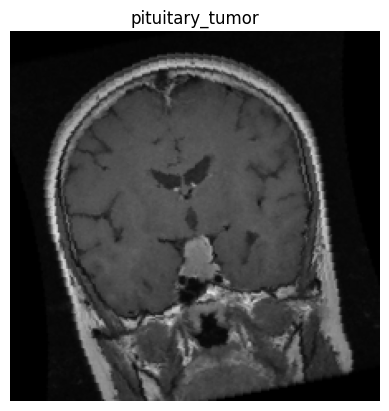

In [11]:
def imshow(img, label):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    plt.title(class_names[label])
    plt.axis("off")
    plt.show()

# Get one batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display the first image
imshow(images[0], labels[0].item())